# **Applied AI in Biomedicine - Final Assignment**
## PAC/PVC classification from ECG signals
***
* Alberto Rota: *Person Code: 10615751 - Student Number: 964662 - [alberto2.rota@mail.polimi.it](mailto:alberto2.rota@mail.polimi.it)*  
* Gabriele Santicchi: *Person Code: 10579046 - Student Number: 969088 - [gabriele.santicchi@mail.polimi.it](mailto:gabriele.santicchi@mail.polimi.it)*
***

In [1]:
import os
import numpy as np, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.sans-serif'] = "Times New Roman"
mpl.rcParams['font.size'] = 10

import seaborn as sns
import random
import sklearn
import random

import scipy
from scipy.io import loadmat
from random import randint

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

import sklearn
from sklearn.model_selection import train_test_split

SEED = 69
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Using Tensorflow version",tf.__version__)
print("RNG seed:", SEED)

color = {
    "lead": "#073b4c",
    "N": "#06d6a0",
    "S": "#ef476f",
    "V": "#ffd166",
    "X": "#118ab2",
}

Using Tensorflow version 2.6.0
RNG seed: 69


In [15]:
!unzip training_set.zip -d data
dataset_dir="data"  # Dataset is located here
images = "" # Images are located here

## Patient class definition

In [6]:
class Patient:
    def __init__(self,init_dict):
        self.path=init_dict['path']
        self.fs=init_dict['fs']
        self.id=init_dict['id']
        self.rpeaks=init_dict['rpeaks']
        self.peaklabels=init_dict['peaklabels']
        self.samples=init_dict['samples']
        self.time=np.arange(0,self.samples/self.fs,1/self.fs)
        self.lead1=init_dict['lead1']
        self.lead2=init_dict['lead2']
        if self.fs != 128:
            f1 = scipy.interpolate.interp1d(self.time,self.lead1)
            f2 = scipy.interpolate.interp1d(self.time,self.lead2)
            self.time=np.arange(0,self.samples/self.fs,1/self.fs)
            self.fs = 128.0
            self.lead1 = f1(self.time)
            self.lead2 = f2(self.time)
        
        insideborders = np.logical_and(self.rpeaks>0, self.rpeaks<self.samples)
        
        if self.rpeaks.shape[0]-np.count_nonzero(insideborders)>0: 
            print(f"PATIENT {self.id}: Found {self.rpeaks.shape[0]-np.count_nonzero(insideborders)} samples out of bounds")
            self.rpeaks = self.rpeaks[insideborders]
            self.peaklabels = self.peaklabels[insideborders]
                                
    def info(self):
        print(">> ID:",self.id)
        print(" | Path:",self.path)
        print(" | fs:",self.fs)
        print(" | samples:",self.samples)
        print(" | lead1:",self.lead1)
        print(" | lead2:",self.lead2)
        print(" | rpeaks:",self.rpeaks)
        print(" | peaklabels:",self.peaklabels)
        
    def plot(self,windowstart=None,xrange=4000,splitleads=False):
        if windowstart is None: windowstart = randint(0,self.samples-xrange)
        
        if not splitleads: 
            fig = plt.figure(figsize=(4,3),constrained_layout=True)
            plt.subplot(2,1,1)
        if splitleads: fig = plt.figure(figsize=(4,2))
        plt.plot(self.time,self.lead1,color=color['lead'])
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='N']],
            color=color['N'],s=200,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='S']],
            color=color['S'],s=200,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead1[self.rpeaks[self.peaklabels=='V']],
            color=color['V'],s=200,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title(f"Patient #{self.id} - ECG lead 1")
        if splitleads: plt.xlabel("Time [seconds]")
        if splitleads: plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),ncol=3)
        if splitleads: plt.show()
        
        if not splitleads: 
            plt.subplot(2,1,2)
        if splitleads: plt.figure(figsize=(4,2))
        plt.plot(self.time,self.lead2,color=color['lead'])
        plt.scatter(self.rpeaks[self.peaklabels=='N']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='N']],
            color=color['N'],s=200,alpha=0.5,label="Normal")
        plt.scatter(self.rpeaks[self.peaklabels=='S']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='S']],
            color=color['S'],s=200,alpha=0.5,label="SopraVentricular")
        plt.scatter(self.rpeaks[self.peaklabels=='V']/self.fs,self.lead2[self.rpeaks[self.peaklabels=='V']],
            color=color['V'],s=200,alpha=0.5,label="Ventricular")
        plt.grid(True)
        plt.xlim([windowstart/self.fs,(windowstart+xrange)/self.fs])
        plt.title(f"Patient #{self.id} - ECG lead 2")
        plt.xlabel("Time [seconds]")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),ncol=3)
        plt.show()
        return fig
    
    def split_RRR(self,borders=0.05, fixed_length=False):
        border_samples = round(borders*(self.rpeaks[0]))
        
        wl1 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        wl2 = [self.lead1[0:(self.rpeaks[0]-border_samples)]]
        
        for p in range(1,self.rpeaks.shape[0]-1):
            border_samples = round(borders*(self.rpeaks[p+1]-self.rpeaks[p-1]))
            window = self.lead1[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl1.append(window)
            window = self.lead2[(self.rpeaks[p-1]+border_samples):(self.rpeaks[p+1]-border_samples)]
            wl2.append(window)
        
        border_samples = round(borders*(self.rpeaks[0]))
        wl1.append(self.lead1[self.rpeaks[-1]:self.samples])
        wl2.append(self.lead1[self.rpeaks[-1]:self.samples])
        
        if fixed_length != False:
            r1,r2 = [],[]
            for i,_ in enumerate(wl1):
                if wl1[i].shape[0] >= fixed_length:
                    r1.append(
                        wl1[i][wl1[i].shape[0]//2-fixed_length//2:wl1[i].shape[0]//2+(fixed_length-fixed_length//2)]
                    )
                    r2.append(
                        wl2[i][wl2[i].shape[0]//2-fixed_length//2:wl2[i].shape[0]//2+(fixed_length-fixed_length//2)]
                    )
                elif wl1[i].shape[0] < fixed_length:
                    padleft  = (fixed_length-wl1[i].shape[0])//2
                    padright = fixed_length-padleft-wl1[i].shape[0]
                    r1.append(
                        np.pad(wl1[i], (padleft,padright), mode='edge')
                    )
                    r2.append(
                        np.pad(wl2[i], (padleft,padright), mode='edge')
                    )
                elif wl1[i].shape[0] == fixed_length:
                    r1.append(
                        wl1[i][-fixed_length:]
                    )
                    r2.append(
                        wl2[i][-fixed_length:]
                    )
            wl1,wl2 = r1,r2
        return wl1,wl2
        
    def split_windows(self, width=100):
        wl1,wl2=[],[]
        
        right = width//2
        left = width-right
        LEN = self.lead1.shape[0]

        for i in range(self.rpeaks.shape[0]):
            peak = self.rpeaks[i]
            
            if peak-left >= 0 and peak+right < LEN: 
                window = self.lead1[(peak-left):(peak+right)]
            elif peak-left < 0:
                window = np.pad(self.lead1[0:(peak+right)],(abs(width-(peak+right)),0))
                
            elif peak+right >= LEN:
                window = np.pad(self.lead1[(peak-left):LEN],(0,abs(width-(LEN-(peak-left)))))
                
            wl1.append(window)
            
            if peak-left >= 0 and peak+right < LEN: 
                window = self.lead2[(peak-left):(peak+right)]
            elif peak-left < 0:
                window = np.pad(self.lead2[0:(peak+right)],(abs(width-(peak+right)),0))
                
            elif peak+right >= LEN:
                window = np.pad(self.lead2[(peak-left):LEN],(0,abs(width-(LEN-(peak-left)))))
            
            wl2.append(window)

        return wl1,wl2
    
    def countnans(self):
        return np.count_nonzero(np.isnan(self.lead1))+np.count_nonzero(np.isnan(self.lead2))

## Data Loading

In [7]:
files = sorted(os.listdir(dataset_dir))
patient = []
correct,ncorrect=0,0
nans=0
for f in range(0,len(files),3):
    try: 
        recs = loadmat(os.path.join(dataset_dir,files[f]))
        ann = loadmat(os.path.join(dataset_dir,files[f+1]))
        rp =loadmat(os.path.join(dataset_dir,files[f+2]))
        patient_as_dict={
                'id':files[f].split(".")[0].split("_")[0],
                'path':os.path.join("data",files[f]),
                'fs':float(files[f].split(".")[0].split("_")[1]),
                'samples':recs['ecg'][:,0].shape[0],
                'lead1':recs['ecg'][:,0],
                'lead2':recs['ecg'][:,1],
                'rpeaks':rp['rpeaks'].T[0],
                'peaklabels':ann['labels'] 
        }
        patient.append(Patient(patient_as_dict))
        nans += patient[-1].countnans()
        correct+=1
        
    except:
        ncorrect+=1
        
print(f"Loaded {correct} files correctly")
if ncorrect>0: print(f"!!!! Error in loading {ncorrect} files")
if nans>0: print("Found: ",nans, "missing values")
ptest = patient[9] # Test patient

PATIENT S005: Found 1 samples out of bounds
PATIENT S009: Found 1 samples out of bounds
Loaded 105 files correctly


### Examples of ECG Signals

Uncomment lines to plot the signals as described on the right

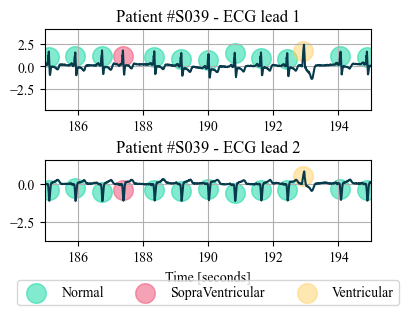

In [10]:
fig = patient[38].plot(185*patient[38].fs,10*patient[38].fs)    # 1 Sopraventricular, 1 Ventricular
# fig = patient[38].plot()                                      # 1 Sopraventricular, 1 Ventricular
# patient[13].plot()                                            # Lots of Sopraventriculars
# patient[9].plot(1075*patient[38].fs,10*patient[38].fs)        # Lots of both Sopraventriculars and Ventriculars
# patient[0].plot(60000,5000)                                   # Baseline wonder

## Window splitting

Plotting the histogram of the RRR intervals and the pathological heartbeat distance 

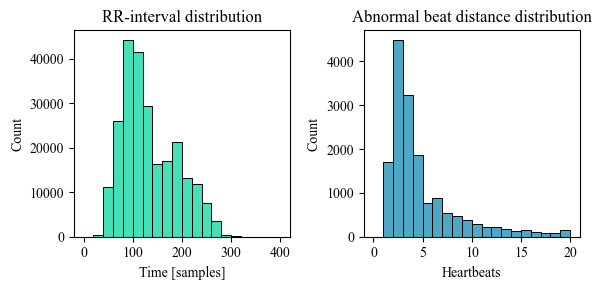

In [16]:
ints = []
wins = []
N_count = 0
S_count = 0
V_count = 0

for ptest in patient:
    nn = np.where(np.logical_or(ptest.peaklabels=='V',ptest.peaklabels=='S'))
    intervals = np.diff(nn)[0]
    wins.append(np.diff(ptest.rpeaks))
    ints.append(intervals)
    N_count+=np.count_nonzero(ptest.peaklabels=='N')
    S_count+=np.count_nonzero(ptest.peaklabels=='S')
    V_count+=np.count_nonzero(ptest.peaklabels=='V')
    
intervals = np.concatenate(ints,axis=0)
RRR = np.concatenate(wins,axis=0)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
sns.histplot(RRR,bins=20,binrange=[0,400], color = color['N'])
plt.xlabel("Time [samples]")
plt.title("RR-interval distribution")
plt.subplot(1,2,2)
sns.histplot(intervals,bins=20,binrange=[0,20], color = color['X'])
plt.xlabel("Heartbeats")
plt.title("Abnormal beat distance distribution")
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.savefig(os.path.join(images,"histograms.jpg"),dpi=200)
plt.show()

Difference in splitting strategies:
* **`Split_RRR(fixed_length==False)`** keeps only the desired R-peak in the window --> INCONSISTENCY in window length

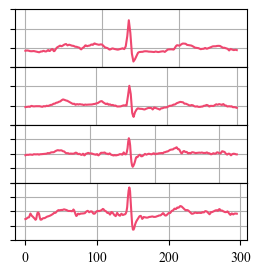

In [17]:
split1,_ = ptest.split_RRR(borders=0.05)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(3,3))
for p,i in enumerate(idxs):
    plt.subplot(4,1,p+1)
    plt.plot(split1[i],color=color['S'])
    # plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
plt.show()

* **`Split_RRR(fixed_length==True)`** keeps only the desired R-peak in the window and pads/cuts to fix the window width --> CONSISTENCY in window length

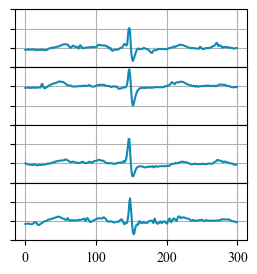

In [18]:
split1,_ = ptest.split_RRR(borders=0.05,fixed_length=300)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(3,3))
for p,i in enumerate(idxs):
    plt.subplot(4,1,p+1)
    plt.plot(split1[i],color=color['X'])
    # plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
plt.show()

* **`split_windows(width=150)`** slices a fixed number of samples around each R-peak --> Multiple peaks may appear in the same window

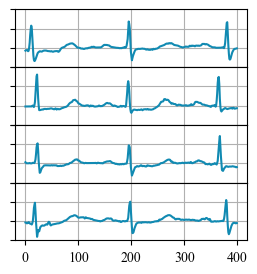

In [19]:
split1,_ = ptest.split_windows(400)
idxs = [randint(0,1000) for _ in range(4)]
plt.figure(figsize=(3,3))
for p,i in enumerate(idxs):
    plt.subplot(4,1,p+1)
    plt.plot(split1[i],color=color['X'])
    # plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.grid(True)
plt.show()

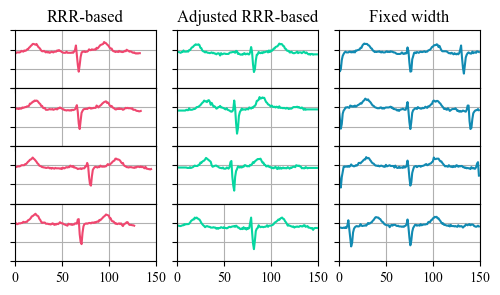

In [20]:
ptest = patient[40]
split1,_ = ptest.split_RRR(borders=0.05)
idxs = [randint(0,1000) for _ in range(4)]

fig = plt.figure(figsize=(6,3))
for p,i in enumerate(idxs):
    plt.subplot(4,3,3*p+1)
    plt.plot(split1[i],color=color['S'])
    # plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    if not p==3: 
        xt,_ = plt.xticks()
        plt.xticks(ticks=xt,labels=[])
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0.15, hspace=0)
    plt.grid(True)
    plt.xlim([-0,150])
    if p==0: plt.title("RRR-based")

split1,_ = ptest.split_RRR(borders=0.05,fixed_length=150)
idxs = [randint(0,1000) for _ in range(4)]
for p,i in enumerate(idxs):
    plt.subplot(4,3,3*p+2)
    plt.plot(split1[i],color=color['N'])
    # plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    if not p==3: 
        xt,_ = plt.xticks()
        plt.xticks(ticks=xt,labels=[])
    plt.yticks(ticks=yt,labels=[])
    plt.subplots_adjust(wspace=0.15, hspace=0)
    plt.grid(True)
    plt.xlim([-0,150])
    if p==0: plt.title("Adjusted RRR-based")

split1,_ = ptest.split_windows(150)
idxs = [randint(0,1000) for _ in range(4)]
for p,i in enumerate(idxs):
    plt.subplot(4,3,3*p+3)
    plt.plot(split1[i],color=color['X'])
    # plt.title(f"W{i}: length={len(split1[i])}")        
    yt,_ = plt.yticks()
    if not p==3: 
        xt,_ = plt.xticks()
        plt.xticks(ticks=xt,labels=[],)
    plt.yticks(ticks=yt,labels=[],)
    plt.subplots_adjust(wspace=0.15, hspace=0)
    plt.grid(True)
    plt.xlim([-0,150])
    if p==0: plt.title("Fixed width")
# plt.constrained_layout()
plt.show()
fig.savefig(os.path.join(images,"windowing.jpg"),dpi=200,)

### Analyzing the class imbalance

In [24]:
N,S,V = 0,0,0
X=0
l=0
for p in patient:
    l+=p.peaklabels.shape[0]
    N+=np.count_nonzero(p.peaklabels=='N')
    S+=np.count_nonzero(p.peaklabels=='S')
    V+=np.count_nonzero(p.peaklabels=='V')
print("NUMBER OF BEATS: Normal: ",N,"- Sopraventricualar: ",S,"- Ventricular:",V)
print("PERCENTAGE: Normal: ",N/(N+S+V),"- Sopraventricualar: ",S/(N+S+V),"- Ventricular:",V/(N+S+V),)

NUMBER OF BEATS: Normal:  226930 - Sopraventricualar:  9609 - Ventricular: 7795
PERCENTAGE: Normal:  0.9287696350078172 - Sopraventricualar:  0.03932731425016576 - Ventricular: 0.031903050742017075


## Label encoding
* **N**: Normal
* **S**: Sopraventricular
* **V**: Ventricular
* **X**: A virtual label used to classify the first beats in the recording, on which there is no information about the past

In [25]:
categorical = {'X':np.array([1,0,0,0]),'N':np.array([0,1,0,0]),'S':np.array([0,0,1,0]),'V':np.array([0,0,0,1])}

## Building the Dataset
And performing patient-wise undersampling on N windows

In [26]:
N_to_take = round(min([V_count,N_count,S_count])/len(patient))

def build_dataset(patients, width=150):
    XtrainWins=[]
    XtrainPast=[]
    Ytrain=[]
    for p in patients:
        split1,split2 = p.split_RRR(borders=0.05, fixed_length=width)
        vect = np.arange(0,len(split1))
        np.random.shuffle(vect)
        N = 0
        for i in vect:
            if (p.peaklabels[i] != 'N' ):
                XtrainWins.append(
                    np.column_stack((split1[i],split2[i]))
                )
                Ytrain.append(
                    categorical[p.peaklabels[i]]
                )
                if i>=2:
                    XtrainPast.append(
                        np.array([categorical[p.peaklabels[i-2]],categorical[p.peaklabels[i-1]]])
                    )
                elif i==1:
                    XtrainPast.append(
                        np.array([categorical['X'],categorical[p.peaklabels[i-1]]])
                    )
                else:
                    XtrainPast.append(
                        np.array([categorical['X'],categorical['X']])
                    )
            if (p.peaklabels[i] == 'N' and N < N_to_take):
                XtrainWins.append(
                np.column_stack((split1[i],split2[i]))
                )
                Ytrain.append(
                    categorical[p.peaklabels[i]]
                )
                if i>=2:
                    XtrainPast.append(
                        np.array([categorical[p.peaklabels[i-2]],categorical[p.peaklabels[i-1]]])
                    )
                elif i==1:
                    XtrainPast.append(
                        np.array([categorical['X'],categorical[p.peaklabels[i-1]]])
                    )
                else:
                    XtrainPast.append(
                        np.array([categorical['X'],categorical['X']])
                    )
                N = N + 1
            
    return (np.stack(XtrainWins,axis=0),np.stack(XtrainPast,axis=0)),np.stack(Ytrain,axis=0)

(XtrainW,XtrainP),Ytrain=build_dataset(patient,150)

print(f"INPUT WINDOW shape: {XtrainW.shape} as (WINDOW, TIME, LEAD)")
print(f"INPUT PAST shape: {XtrainP.shape} as (WINDOW, PAST, one-hot-LABEL)")
print(f"OUTPUT shape: {Ytrain.shape} as (WINDOW, one-hot-LABEL)")

INPUT WINDOW shape: (25174, 150, 2) as (WINDOW, TIME, LEAD)
INPUT PAST shape: (25174, 2, 4) as (WINDOW, PAST, one-hot-LABEL)
OUTPUT shape: (25174, 4) as (WINDOW, one-hot-LABEL)


### Train-Test-Validation Split

In [27]:
from sklearn.model_selection import train_test_split

XtrainW,XvalW,XtrainP,XvalP,Ytrain,Yval = train_test_split(
    XtrainW,XtrainP,Ytrain, test_size=0.3, shuffle=True, stratify=Ytrain)

XvalW,XtestW,XvalP,XtestP,Yval,Ytest = train_test_split(
    XvalW,XvalP,Yval, test_size=0.3, shuffle=True, stratify=Yval)

print(f"{len(XtrainW)} TRAINING samples: {XtrainW[0].shape}[Window] + {XtrainP[0].shape}[Past Labels] --> {Ytrain[0].shape}[Classification]")
print(f"{len(XvalW)} VALIDATION samples: {XvalW[0].shape}[Window] + {XvalP[0].shape}[Past Labels] --> {Yval[0].shape}[Classification]")
print(f"{len(XtestW)} TESTING samples: {XtestW[0].shape}[Window] + {XtestP[0].shape}[Past Labels] --> {Ytest[0].shape}[Classification]")    

17621 TRAINING samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]
5287 VALIDATION samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]
2266 TESTING samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]


### Standardization

In [28]:
Xtrain_res = np.concatenate(XtrainW)
Xtrain_res.shape
l1_mean,l1_std = np.mean(Xtrain_res[:,0]),np.std(Xtrain_res[:,0])
l2_mean,l2_std = np.mean(Xtrain_res[:,1]),np.std(Xtrain_res[:,1])
print(f"Lead1: mean = {l1_mean} std = {l1_std}")
print(f"Lead2: mean = {l2_mean} std = {l2_std}")

Lead1: mean = -0.027238111722755032 std = 0.5311068977013593
Lead2: mean = -0.015495476987685174 std = 0.3853646253951701


In [29]:
XtrainW[:,:,0] = (XtrainW[:,:,0]-l1_mean)/l1_std 
XtrainW[:,:,1] = (XtrainW[:,:,1]-l2_mean)/l2_std 

XvalW[:,:,0] = (XvalW[:,:,0]-l1_mean)/l1_std 
XvalW[:,:,1] = (XvalW[:,:,1]-l2_mean)/l2_std 

XtestW[:,:,0] = (XtestW[:,:,0]-l1_mean)/l1_std 
XtestW[:,:,1] = (XtestW[:,:,1]-l2_mean)/l2_std 

Xtrain_res = np.concatenate(XtrainW)
train1_mean,train1_std = np.mean(Xtrain_res[:,0]),np.std(Xtrain_res[:,0])
train2_mean,train2_std = np.mean(Xtrain_res[:,1]),np.std(Xtrain_res[:,1])
print(f"Training L1: mean = {train1_mean} std = {train1_std}")
print(f"Training L2: mean = {train2_mean} std = {train2_std}")

Xtest_res = np.concatenate(XtestW)
test1_mean,test1_std = np.mean(Xtest_res[:,0]),np.std(Xtest_res[:,0])
test2_mean,test2_std = np.mean(Xtest_res[:,1]),np.std(Xtest_res[:,1])
print(f"Test L1: mean = {test1_mean} std = {test1_std}")
print(f"Test L2: mean = {test2_mean} std = {test2_std}")

Xval_res = np.concatenate(XvalW)
val1_mean,val1_std = np.mean(Xval_res[:,0]),np.std(Xval_res[:,0])
val2_mean,val2_std = np.mean(Xval_res[:,1]),np.std(Xval_res[:,1])
print(f"valing L1: mean = {val1_mean} std = {val1_std}")
print(f"valing L2: mean = {val2_mean} std = {val2_std}")


Training L1: mean = -2.4764087099945303e-17 std = 1.0
Training L2: mean = 6.251776048592358e-17 std = 0.9999999999999996
Test L1: mean = 0.00377064579161553 std = 1.0053924126141955
Test L2: mean = -0.016181702591007884 std = 0.9896217073931475
valing L1: mean = 0.002095884129648376 std = 0.9932022396859752
valing L2: mean = 0.006177569194265232 std = 0.9677970967922943


# Building the Time Model

Model: "PAC_PVC_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputWin (InputLayer)           [(None, 150, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 150, 128)     67072       InputWin[0][0]                   
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 146, 8)       5128        lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 146, 128)     70144       conv1d[0][0]                     
_________________________________________________________________________________

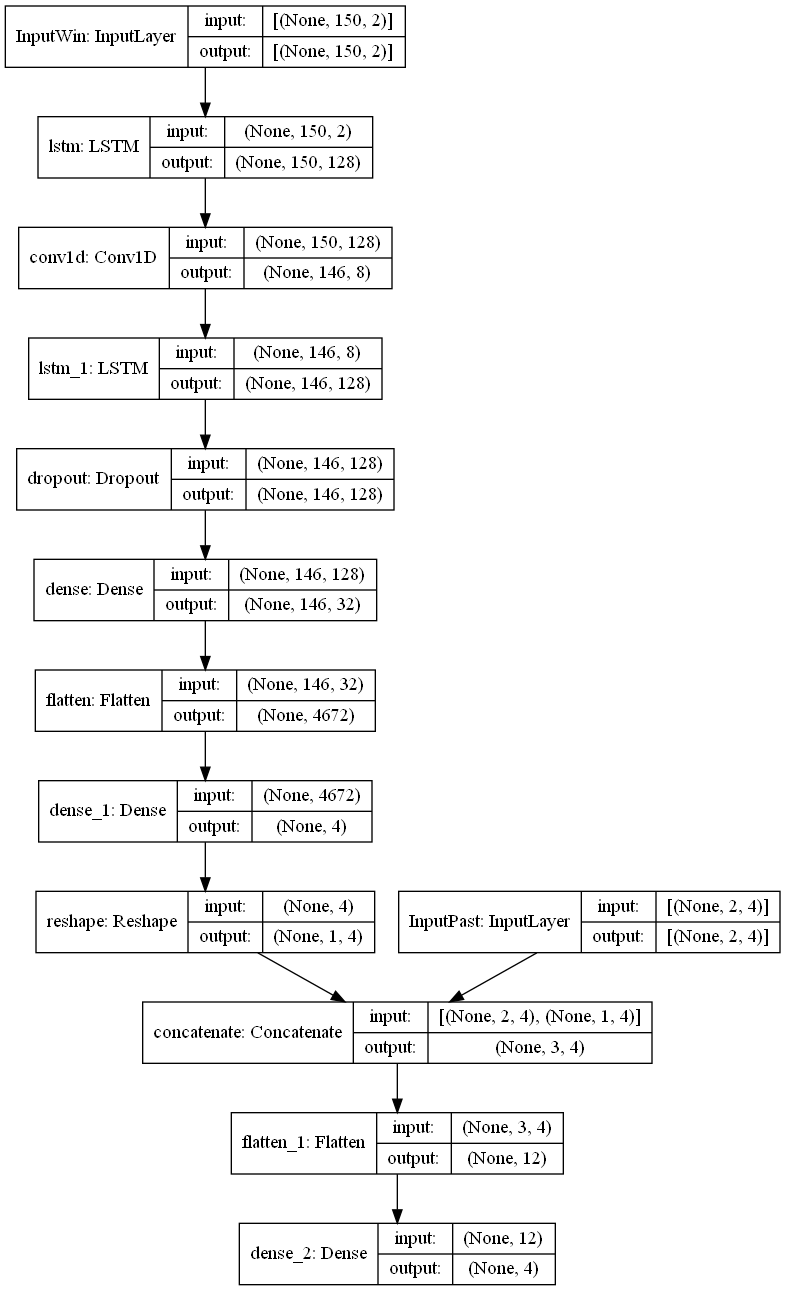

In [30]:
def build_time_model(inputwin_shape,inputpast_shape, classes):
    
    inputwin_layer = tfkl.Input(shape=inputwin_shape, name='InputWin')
    inputpast_layer = tfkl.Input(shape=inputpast_shape, name='InputPast')

    x = tfkl.LSTM(128, return_sequences=True)(inputwin_layer)
    x = tfkl.Conv1D(filters = 8, kernel_size=5)(x)
    x = tfkl.LSTM(128,return_sequences=True)(x)
    x = tfkl.Dropout(.5, seed=SEED)(x)
    x = tfkl.Dense(32, activation='relu')(x)
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(classes, activation='softmax')(x)
    
    x2 = tfkl.Reshape((1,4))(x)
    xc = tfkl.Concatenate(axis=1)([inputpast_layer,x2])
    x = tfkl.Flatten()(xc)
    output_layer = tfkl.Dense(classes,activation='softmax')(x)
    
    model = tfk.Model(inputs=[inputwin_layer,inputpast_layer], outputs=output_layer, name='PAC_PVC_classifier')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model 

timemodel = build_time_model(inputwin_shape=XtrainW[0].shape,inputpast_shape=XtrainP[0].shape, classes=4)
timemodel.summary()
tfk.utils.plot_model(timemodel,show_shapes=True)

# Building the Frequency Model

Model: "PAC_PVC_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputWin (InputLayer)           [(None, 150, 2)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 148, 16)      112         InputWin[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 148, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 74, 16)       0           activation[0][0]                 
_________________________________________________________________________________

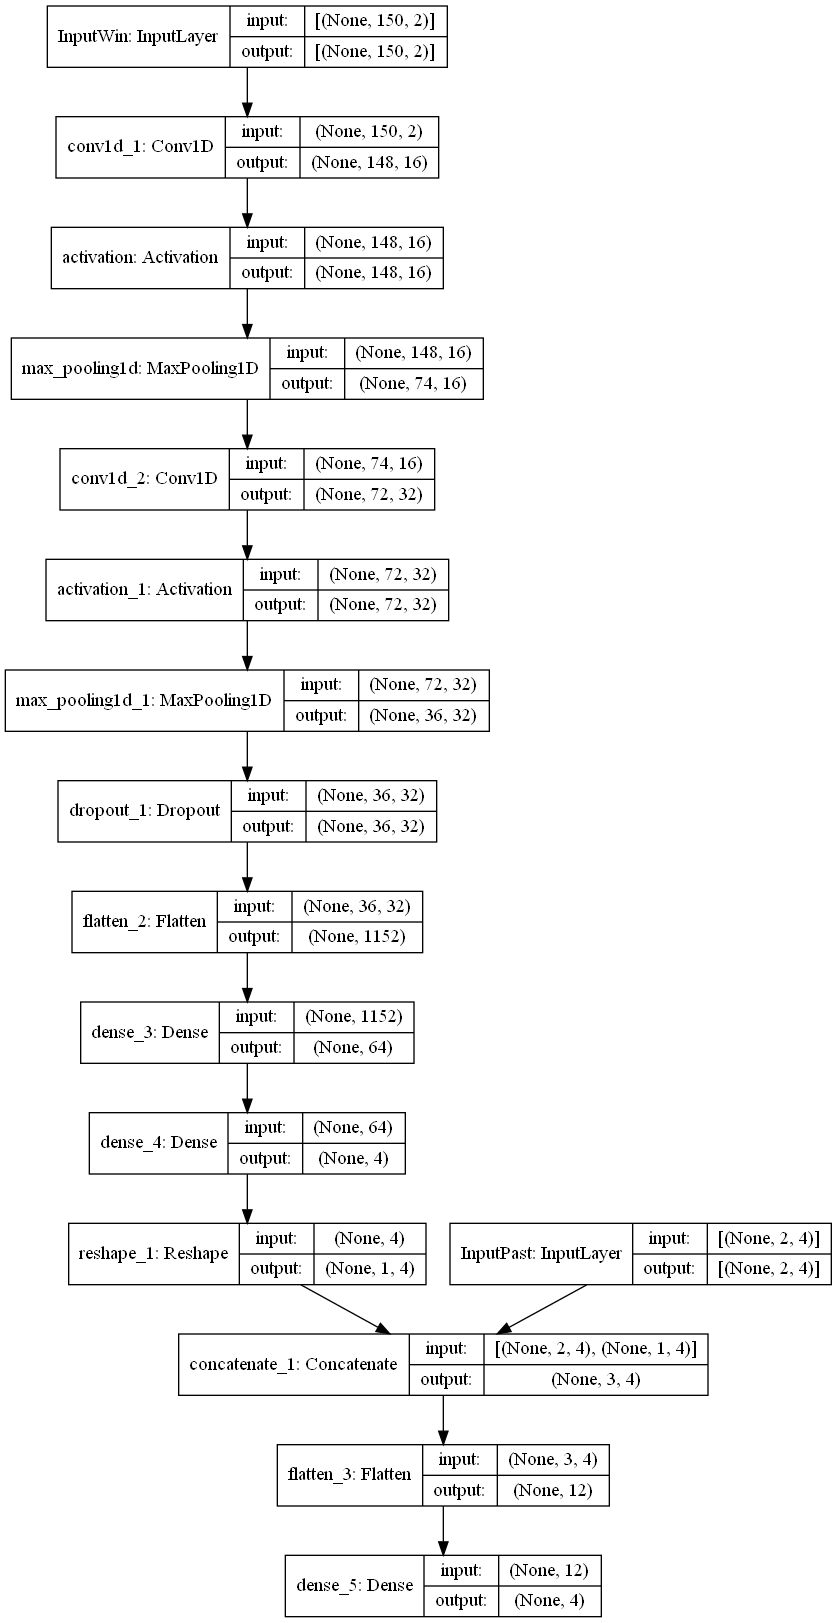

In [31]:
def build_freq_model(inputwin_shape,inputpast_shape, classes):
    
    inputwin_layer = tfkl.Input(shape=inputwin_shape, name='InputWin')
    inputpast_layer = tfkl.Input(shape=inputpast_shape, name='InputPast')

    x = tfkl.Conv1D(filters = 16, kernel_size=3)(inputwin_layer)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling1D(2)(x)
    x = tfkl.Conv1D(filters = 32, kernel_size=3)(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling1D(2)(x)
    x = tfkl.Dropout(.5, seed=SEED)(x)
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(64, activation='relu')(x)
    x = tfkl.Dense(classes, activation='softmax')(x)
    
    x2 = tfkl.Reshape((1,4))(x)
    xc = tfkl.Concatenate(axis=1)([inputpast_layer,x2])
    x = tfkl.Flatten()(xc)
    output_layer = tfkl.Dense(classes,activation='softmax')(x)
    
    model = tfk.Model(inputs=[inputwin_layer,inputpast_layer], outputs=output_layer, name='PAC_PVC_classifier')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model 

freqmodel = build_freq_model(inputwin_shape=XtrainW[0].shape,inputpast_shape=XtrainP[0].shape, classes=4)
freqmodel.summary()
tfk.utils.plot_model(freqmodel,show_shapes=True)

### Class Weight

After the undesampling procedure, the dataset is not unbalanced anymore

In [98]:
print("CLASS WEIGHTING")
N_count=np.count_nonzero(np.argmax(Ytrain,axis=1)==1)
S_count=np.count_nonzero(np.argmax(Ytrain,axis=1)==2)
V_count=np.count_nonzero(np.argmax(Ytrain,axis=1)==3)

N_samples = N_count+V_count+S_count
CLASS_WEIGHT = {
    0:0,
    1:N_samples/(3*N_count),
    2:N_samples/(3*S_count),
    3:N_samples/(3*V_count),
}
print(CLASS_WEIGHT)

CLASS WEIGHTING
{0: 0, 1: 1.0799404605551177, 2: 0.8732653639195695, 3: 1.0765470891158244}


# Training the Time Classifier


INPUT WINDOW shape: (25174, 150, 2) as (WINDOW, TIME, LEAD)
INPUT PAST shape: (25174, 2, 4) as (WINDOW, PAST, one-hot-LABEL)
OUTPUT shape: (25174, 4) as (WINDOW, one-hot-LABEL)

17621 TRAINING samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]
5287 VALIDATION samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]
2266 TESTING samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]

Epoch 1/100
69/69 [==============================] - 7s 51ms/step - loss: 1.1740 - accuracy: 0.4879 - recall_N: 0.0000e+00 - recall_S: 0.0403 - recall_V: 0.4468 - val_loss: 1.0715 - val_accuracy: 0.5740 - val_recall_N: 0.0000e+00 - val_recall_S: 0.0411 - val_recall_V: 0.5895 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 3s 36ms/step - loss: 1.0264 - accuracy: 0.5891 - recall_N: 0.0000e+00 - recall_S: 0.0437 - recall_V: 0.6083 - val_loss: 0.9758 - val_accuracy: 0.6037 - val_recall_N: 6.1275e-04 - val_recall_S: 0.0401 - val_recall_V:

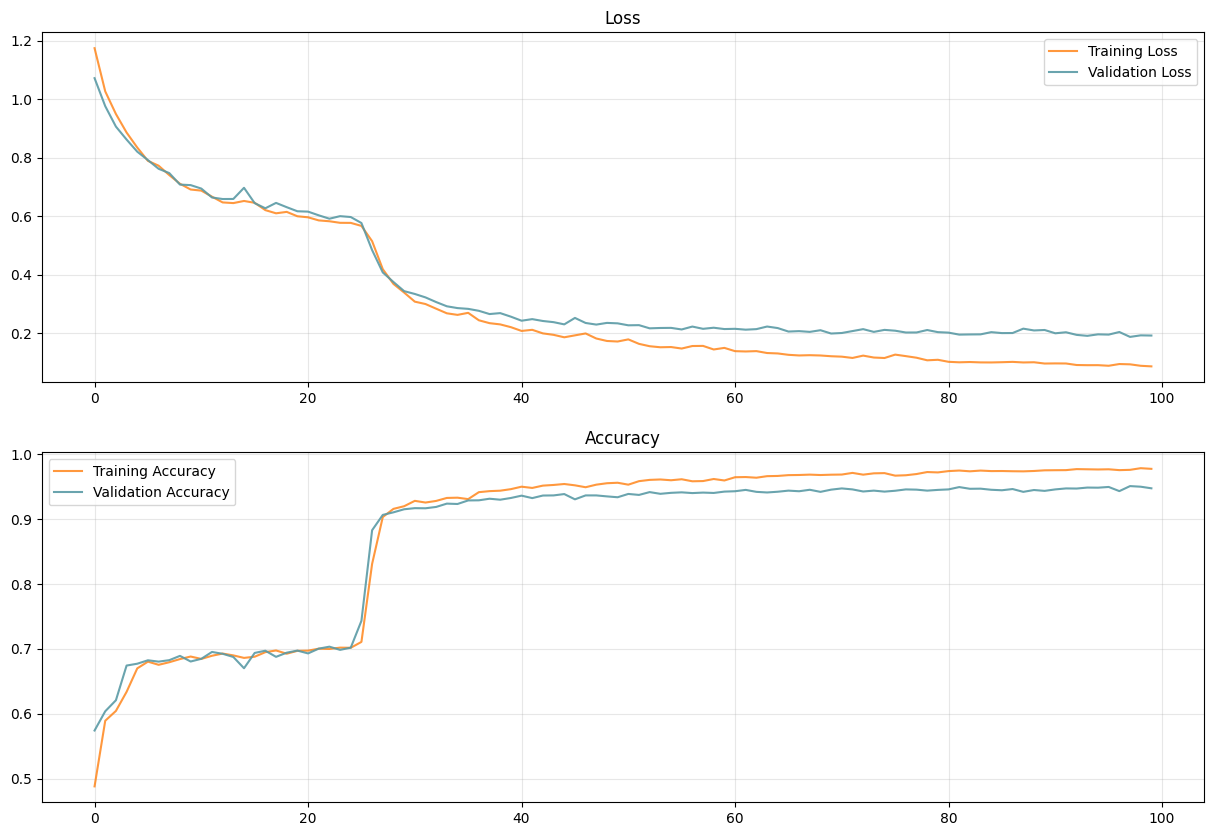

ACCURAY:  0.9545454545454546
CONFUSION MATRIX
[[669  27   3]
 [ 22 823  20]
 [  8  23 671]]


              precision    recall  f1-score   support

           1       0.96      0.96      0.96       699
           2       0.94      0.95      0.95       865
           3       0.97      0.96      0.96       702

    accuracy                           0.95      2266
   macro avg       0.96      0.95      0.96      2266
weighted avg       0.95      0.95      0.95      2266



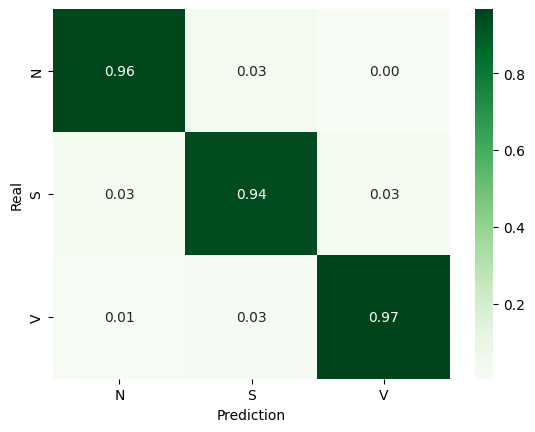

In [100]:
BATCH_SIZE=256
EPOCHS=100
LEARNING_RATE=1e-3

(XtrainW,XtrainP),Ytrain=build_dataset(patient,150)
print()
print(f"INPUT WINDOW shape: {XtrainW.shape} as (WINDOW, TIME, LEAD)")
print(f"INPUT PAST shape: {XtrainP.shape} as (WINDOW, PAST, one-hot-LABEL)")
print(f"OUTPUT shape: {Ytrain.shape} as (WINDOW, one-hot-LABEL)")

XtrainW,XvalW,XtrainP,XvalP,Ytrain,Yval = train_test_split(
    XtrainW,XtrainP,Ytrain, test_size=0.3, shuffle=True, stratify=Ytrain)

XvalW,XtestW,XvalP,XtestP,Yval,Ytest = train_test_split(
    XvalW,XvalP,Yval, test_size=0.3, shuffle=True, stratify=Yval)
print()
print(f"{len(XtrainW)} TRAINING samples: {XtrainW[0].shape}[Window] + {XtrainP[0].shape}[Past Labels] --> {Ytrain[0].shape}[Classification]")
print(f"{len(XvalW)} VALIDATION samples: {XvalW[0].shape}[Window] + {XvalP[0].shape}[Past Labels] --> {Yval[0].shape}[Classification]")
print(f"{len(XtestW)} TESTING samples: {XtestW[0].shape}[Window] + {XtestP[0].shape}[Past Labels] --> {Ytest[0].shape}[Classification]")
print()
timemodel = build_time_model(inputwin_shape=XtrainW[0].shape,inputpast_shape=XtrainP[0].shape, classes=4)

timemodel.compile(
    loss = tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics = [
        'accuracy',
        tfk.metrics.Recall(class_id=1,name='recall_N'),
        tfk.metrics.Recall(class_id=2,name='recall_S'),
        tfk.metrics.Recall(class_id=3,name='recall_V'),
    ]
)

history = timemodel.fit(
    x = [XtrainW,XtrainP],
    y = Ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,  
    validation_data=([XvalW,XvalP],Yval),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='recall_S', mode='max', patience=50),        
        tfk.callbacks.EarlyStopping(monitor='recall_V', mode='max', patience=50),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, verbose=1)
    ],
).history

print(">> TRAINING HISTORY")
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history['loss'], label='Training Loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.9, color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.subplot(2,1,2)
plt.plot(history['accuracy'], label='Training Accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=.9, color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

preds=np.argmax(timemodel.predict([XtestW, XtestP]),axis=1)
Ytestt = np.argmax(Ytest,axis=1)
corrects = preds==Ytestt
print("ACCURAY: ",np.count_nonzero(corrects)/corrects.shape[0])

print("CONFUSION MATRIX")
print(sklearn.metrics.confusion_matrix(Ytestt,preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt,preds))

cmt = sklearn.metrics.confusion_matrix(Ytestt,preds)/np.sum(sklearn.metrics.confusion_matrix(Ytestt,preds),axis=0)
hm=sns.heatmap(cmt,annot=True,fmt=".2f",cmap="Greens")
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['N','S','V'])
plt.show()

# Training the Frequency classifier


INPUT WINDOW shape: (25174, 150, 2) as (WINDOW, TIME, LEAD)
INPUT PAST shape: (25174, 2, 4) as (WINDOW, PAST, one-hot-LABEL)
OUTPUT shape: (25174, 4) as (WINDOW, one-hot-LABEL)

17621 TRAINING samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]
5287 VALIDATION samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]
2266 TESTING samples: (150, 2)[Window] + (2, 4)[Past Labels] --> (4,)[Classification]

Epoch 1/300
276/276 [==============================] - 3s 7ms/step - loss: 1.1116 - accuracy: 0.5138 - recall_N: 0.0077 - recall_S: 0.1558 - recall_V: 0.0024 - val_loss: 0.9536 - val_accuracy: 0.6187 - val_recall_N: 0.0165 - val_recall_S: 0.2646 - val_recall_V: 0.0202 - lr: 0.0010
Epoch 2/300
276/276 [==============================] - 1s 5ms/step - loss: 0.8860 - accuracy: 0.6217 - recall_N: 0.6304 - recall_S: 0.2532 - recall_V: 0.1549 - val_loss: 0.8289 - val_accuracy: 0.6310 - val_recall_N: 0.7825 - val_recall_S: 0.2963 - val_recall_V: 0.2071 - lr: 

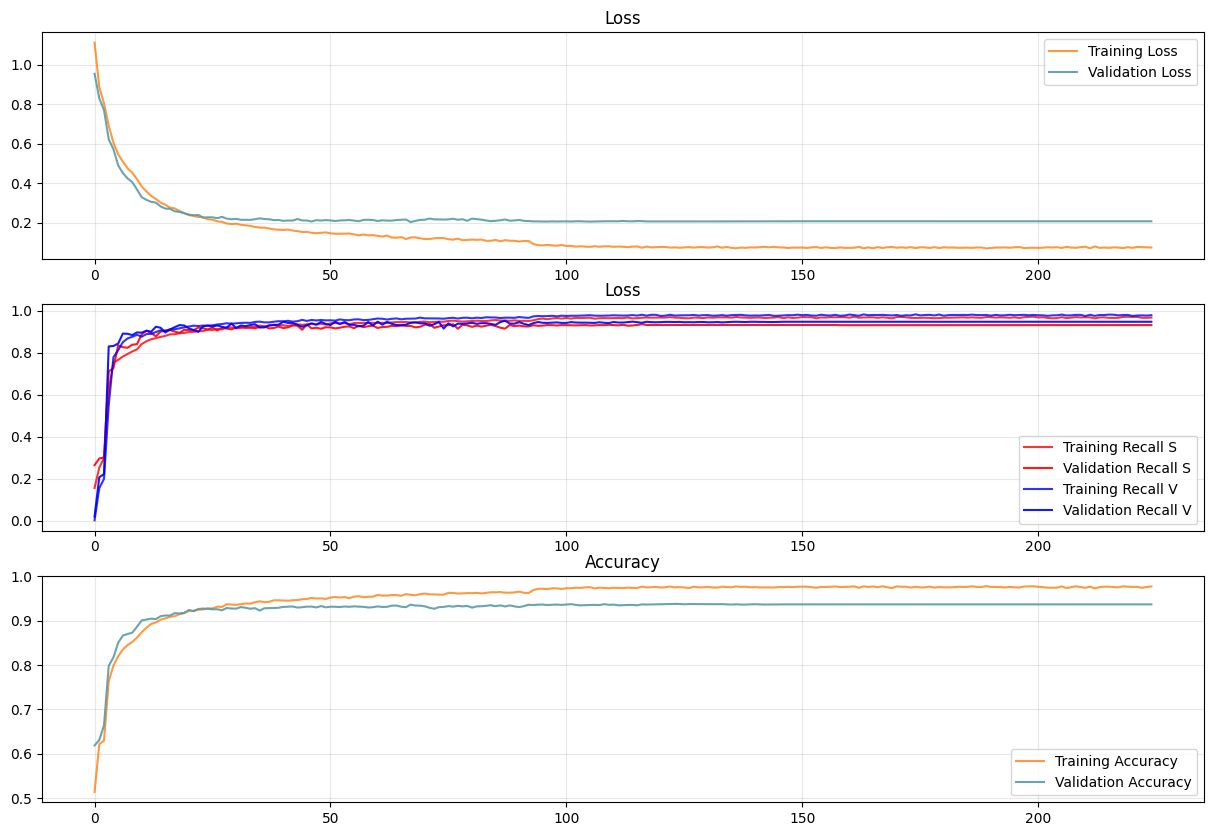

ACCURAY:  0.9435127978817299
CONFUSION MATRIX
[[670  22   7]
 [ 34 801  30]
 [ 11  24 667]]


              precision    recall  f1-score   support

           1       0.94      0.96      0.95       699
           2       0.95      0.93      0.94       865
           3       0.95      0.95      0.95       702

    accuracy                           0.94      2266
   macro avg       0.94      0.94      0.94      2266
weighted avg       0.94      0.94      0.94      2266



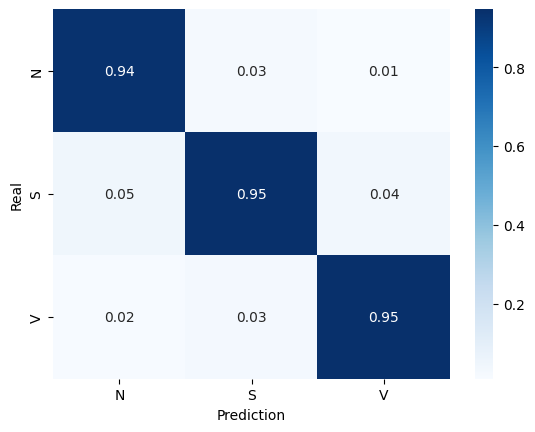

In [101]:
(XtrainW,fXtrainP),fYtrain=build_dataset(patient,150)
fXtrainW = np.fft.fft(XtrainW,axis=1)

print()
print(f"INPUT WINDOW shape: {fXtrainW.shape} as (WINDOW, TIME, LEAD)")
print(f"INPUT PAST shape: {fXtrainP.shape} as (WINDOW, PAST, one-hot-LABEL)")
print(f"OUTPUT shape: {fYtrain.shape} as (WINDOW, one-hot-LABEL)")

fXtrainW,fXvalW,fXtrainP,fXvalP,fYtrain,fYval = train_test_split(
    fXtrainW,fXtrainP,fYtrain, test_size=0.3, shuffle=True, stratify=fYtrain)

fXvalW,fXtestW,fXvalP,fXtestP,fYval,fYtest = train_test_split(
    fXvalW,fXvalP,fYval, test_size=0.3, shuffle=True, stratify=fYval)
print()
print(f"{len(fXtrainW)} TRAINING samples: {fXtrainW[0].shape}[Window] + {fXtrainP[0].shape}[Past Labels] --> {fYtrain[0].shape}[Classification]")
print(f"{len(fXvalW)} VALIDATION samples: {fXvalW[0].shape}[Window] + {fXvalP[0].shape}[Past Labels] --> {fYval[0].shape}[Classification]")
print(f"{len(fXtestW)} TESTING samples: {fXtestW[0].shape}[Window] + {fXtestP[0].shape}[Past Labels] --> {fYtest[0].shape}[Classification]")
print()
BATCH_SIZE=64
EPOCHS=300
LEARNING_RATE=1e-3

freqmodel = build_freq_model(inputwin_shape=fXtrainW[0].shape,inputpast_shape=fXtrainP[0].shape, classes=4)

freqmodel.compile(
    loss = tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics = [
        'accuracy',
        tfk.metrics.Recall(class_id=1,name='recall_N'),
        tfk.metrics.Recall(class_id=2,name='recall_S'),
        tfk.metrics.Recall(class_id=3,name='recall_V'),
    ]
)

history = freqmodel.fit(
    x = [fXtrainW,fXtrainP],
    y = fYtrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT,  
    validation_data=([fXvalW,fXvalP],fYval),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='recall_S', mode='max', patience=50),        
        tfk.callbacks.EarlyStopping(monitor='recall_V', mode='max', patience=50),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
    ],
).history

print(">> TRAINING HISTORY")
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(history['loss'], label='Training Loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.9, color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.subplot(3,1,2)
plt.plot(history['recall_S'], label='Training Recall S', alpha=.8, color='#ff0000')
plt.plot(history['val_recall_S'], label='Validation Recall S', alpha=.9, color='#ff0000')
plt.plot(history['recall_V'], label='Training Recall V', alpha=.8, color='#0000ff')
plt.plot(history['val_recall_V'], label='Validation Recall V', alpha=.9, color='#0000ff')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.subplot(3,1,3)
plt.plot(history['accuracy'], label='Training Accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=.9, color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

preds=np.argmax(freqmodel.predict([fXtestW, fXtestP]),axis=1)
Ytestt = np.argmax(fYtest,axis=1)
corrects = preds==Ytestt
print("ACCURAY: ",np.count_nonzero(corrects)/corrects.shape[0])

print("CONFUSION MATRIX")
print(sklearn.metrics.confusion_matrix(Ytestt,preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt,preds))

cmf = sklearn.metrics.confusion_matrix(Ytestt,preds)/np.sum(sklearn.metrics.confusion_matrix(Ytestt,preds),axis=0)
hm=sns.heatmap(cmf,annot=True,fmt=".2f",cmap="Blues")
hm.set_xticklabels(['N','S','V'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['N','S','V'])
plt.show()

# Testing and Esambling

ACCURAY:  0.972197705207414
[[671  27   1]
 [ 11 844  10]
 [  5   9 688]]


              precision    recall  f1-score   support

           1       0.98      0.96      0.97       699
           2       0.96      0.98      0.97       865
           3       0.98      0.98      0.98       702

    accuracy                           0.97      2266
   macro avg       0.97      0.97      0.97      2266
weighted avg       0.97      0.97      0.97      2266



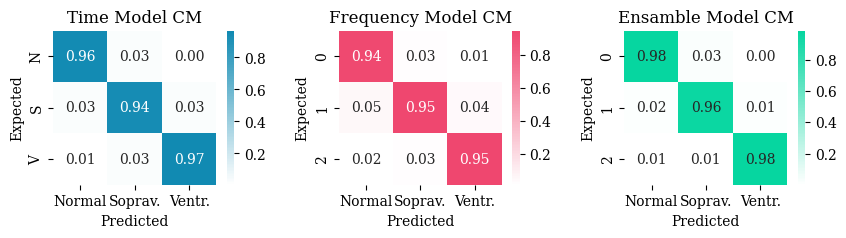

In [110]:
timepreds = timemodel.predict([XtestW, XtestP])
freqpreds = freqmodel.predict([np.fft.fft(XtestW,axis=1), XtestP])
preds = np.argmax(timepreds+freqpreds,axis=1)

Ytestt = np.argmax(Ytest,axis=1)
corrects = preds==Ytestt
print("ACCURAY: ",np.count_nonzero(corrects)/corrects.shape[0])

print(sklearn.metrics.confusion_matrix(Ytestt,preds))
print()
print()
print(sklearn.metrics.classification_report(Ytestt,preds))

cm = sklearn.metrics.confusion_matrix(Ytestt,preds)/np.sum(sklearn.metrics.confusion_matrix(Ytestt,preds),axis=0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from matplotlib.colors import LinearSegmentedColormap
colors = ((1,1,1),(17/255, 138/255, 178/255))
cmapp = LinearSegmentedColormap.from_list('cmapp', colors, N=100)

plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
hm=sns.heatmap(cmt,annot=True,fmt=".2f",cmap=cmapp)
hm.set_xticklabels(['Normal','Soprav.','Ventr.'])
hm.set_xlabel("Predicted")
hm.set_ylabel("Expected")
hm.set_yticklabels(['N','S','V'])
plt.title("Time Model CM")

from matplotlib.colors import LinearSegmentedColormap
colors = ((1,1,1),(239/255, 71/255, 111/255))
cmapp = LinearSegmentedColormap.from_list('cmapp', colors, N=100)


plt.subplot(1,3,2)
hm=sns.heatmap(cmf,annot=True,fmt=".2f",cmap=cmapp)
hm.set_xticklabels(['Normal','Soprav.','Ventr.'])
hm.set_xlabel("Predicted")
hm.set_ylabel("Expected")
plt.title("Frequency Model CM")

from matplotlib.colors import LinearSegmentedColormap
colors = ((1,1,1),(6/255, 214/255, 160/255))
cmapp = LinearSegmentedColormap.from_list('cmapp', colors, N=100)

plt.subplot(1,3,3)
hm=sns.heatmap(cm,annot=True,fmt=".2f",cmap=cmapp)
hm.set_xticklabels(['Normal','Soprav.','Ventr.'])
hm.set_xlabel("Predicted")
hm.set_ylabel("Expected")
plt.title("Ensamble Model CM")

plt.subplots_adjust(wspace=0.4, hspace=0)
plt.show() #

In [103]:
timemodel.save("time.h5")
freqmodel.save("freq.h5")